Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import ViTModel, AutoImageProcessor, AutoConfig

c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from util import *

In [5]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4070 Laptop GPU is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [6]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                v2.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.Resize(224),
                        v2.CenterCrop(224),
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.RandomApply(random_trans, 0.5)])

transform_eval = v2.Compose([v2.Resize(224),
                        v2.CenterCrop(224),
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True)])

In [7]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [8]:
# creat a dictionary that maps index to label
data_dir='../ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [9]:
button_train = CropButtonDataset('../ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=45, shuffle=True)

button_val = CropButtonDataset('../ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=True)

button_test = CropButtonDataset('../ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [10]:
loader_train

In [11]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([20, 3, 224, 224])
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])


Model setup

In [12]:
class ViTBinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = "google/vit-base-patch16-224-in21k",
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face ViT model (e.g., 'google/vit-base-patch16-224-in21k')
            - hidden_dim: hidden dim for classifier
            - dropout_prob: dropout ratio
        """
        super().__init__()

        # 1) Preprocessing for ViT
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)

        # 2) Load ViT pretrained model
        config = AutoConfig.from_pretrained(backbone_name)
        self.backbone = ViTModel.from_pretrained(backbone_name, config=config)

        # 3) Classification head using CLS token
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # Binary output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (B, 3, H, W)
        Output:
            - logits: shape = (B, 1)
        """
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(cls_token)
        return logits

Check augmentation

In [13]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
# processor

test backbone

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = ViTBinaryClassifier(
    backbone_name="google/vit-base-patch16-224-in21k",
    hidden_dim=512,
    dropout_prob=0.4).to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Logits: tensor([[-0.0188],
        [ 0.0199]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


Find best hyperparameter

In [16]:
# arch = ("facebook/dinov2-small", 256, 0.4)
# best_model, best_params, best_training_data = hyperparameter_search(Dinov2BinaryClassifier, arch, loader_train, loader_val, device)

In [17]:
# check_accuracy_final(loader_test, best_model, True)

Train best model

In [18]:
final_model = ViTBinaryClassifier(hidden_dim=256, dropout_prob=0.5)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [19]:
from torchinfo import summary
summary(final_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
ViTBinaryClassifier                                     [1, 1]                    --
├─ViTModel: 1-1                                         [1, 768]                  --
│    └─ViTEmbeddings: 2-1                               [1, 197, 768]             152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [1, 196, 768]             590,592
│    │    └─Dropout: 3-2                                [1, 197, 768]             --
│    └─ViTEncoder: 2-2                                  [1, 197, 768]             --
│    │    └─ModuleList: 3-3                             --                        85,054,464
│    └─LayerNorm: 2-3                                   [1, 197, 768]             1,536
│    └─ViTPooler: 2-4                                   [1, 768]                  --
│    │    └─Linear: 3-4                                 [1, 768]                  590,592
│    │    └─Tanh: 3-5             

In [20]:
# hard code best paramm
lr = 5e-05
wd= 5e-2
beta = (0.9, 0.998)

In [21]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr},
                {"params": final_model.classifier.parameters(), "lr": lr},
            ],
            weight_decay=wd,
            betas= beta)
data = train(final_model, optimizer, loader_train, loader_val, device, earlystop=True, stopsrat=120, epochs=150)

Iter: 1/450   |  Loss: 0.687547  |  Train Acc: 0.5604  |  Val Acc: 0.5000 
Sample preds : [47.0%, 49.1%, 47.9%, 47.4%, 46.8%, 46.9%, 47.2%, 47.5%, 48.3%, 47.0%, 47.5%, 47.7%, 48.4%, 48.4%, 47.3%, 47.3%, 47.2%, 47.1%, 47.8%, 47.6%]
Sample labels: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
Iter: 2/450   |  Loss: 0.687524  |  Train Acc: 0.5495  |  Val Acc: 0.5000 
Iter: 3/450   |  Loss: 0.746127  |  Train Acc: 0.5604  |  Val Acc: 0.5000 
Sample preds : [48.1%, 48.6%, 49.6%, 47.1%, 46.7%, 47.1%, 47.8%, 48.4%, 47.1%, 50.2%, 49.7%, 47.6%, 49.1%, 49.4%, 48.5%, 47.8%, 47.9%, 47.5%, 47.5%, 48.4%]
Sample labels: [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
Iter: 4/450   |  Loss: 0.686123  |  Train Acc: 0.5495  |  Val Acc: 0.5500 
Iter: 5/450   |  Loss: 0.683739  |  Train Acc: 0.5275  |  Val Acc: 0.5500 
Sample preds : [49.1%, 50.3%, 47.7%, 50.7%, 47.3%, 48.9%, 49.5%, 49.1%, 49.1%, 46

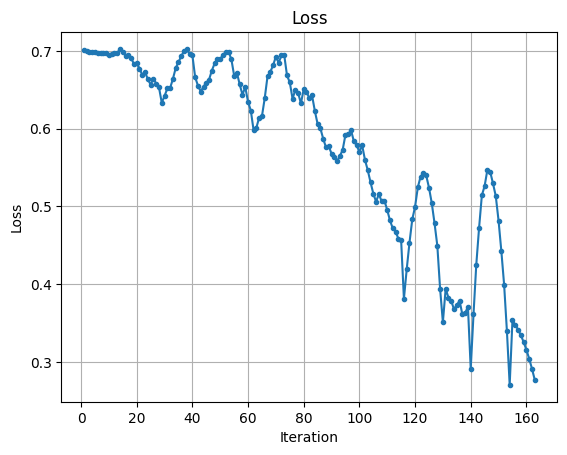

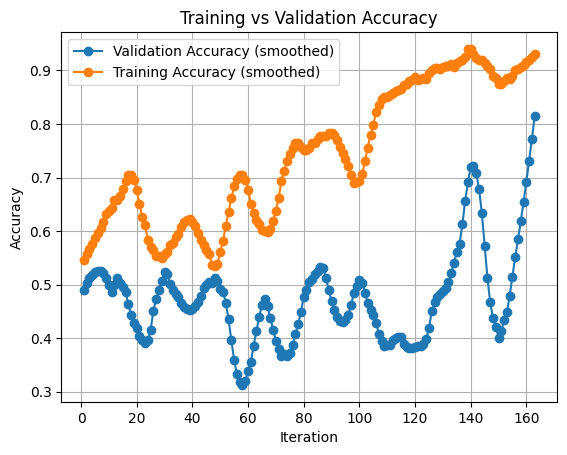

In [22]:
plotpic(data, smooth_window=15)

In [23]:
check_accuracy_final(loader_test, final_model, device, out=True)

Sample preds : [17.4%, 43.1%, 15.7%, 15.7%, 17.5%, 27.7%, 19.4%, 75.8%, 28.4%, 77.5%, 77.3%, 76.4%, 75.8%, 76.8%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.9285714285714286

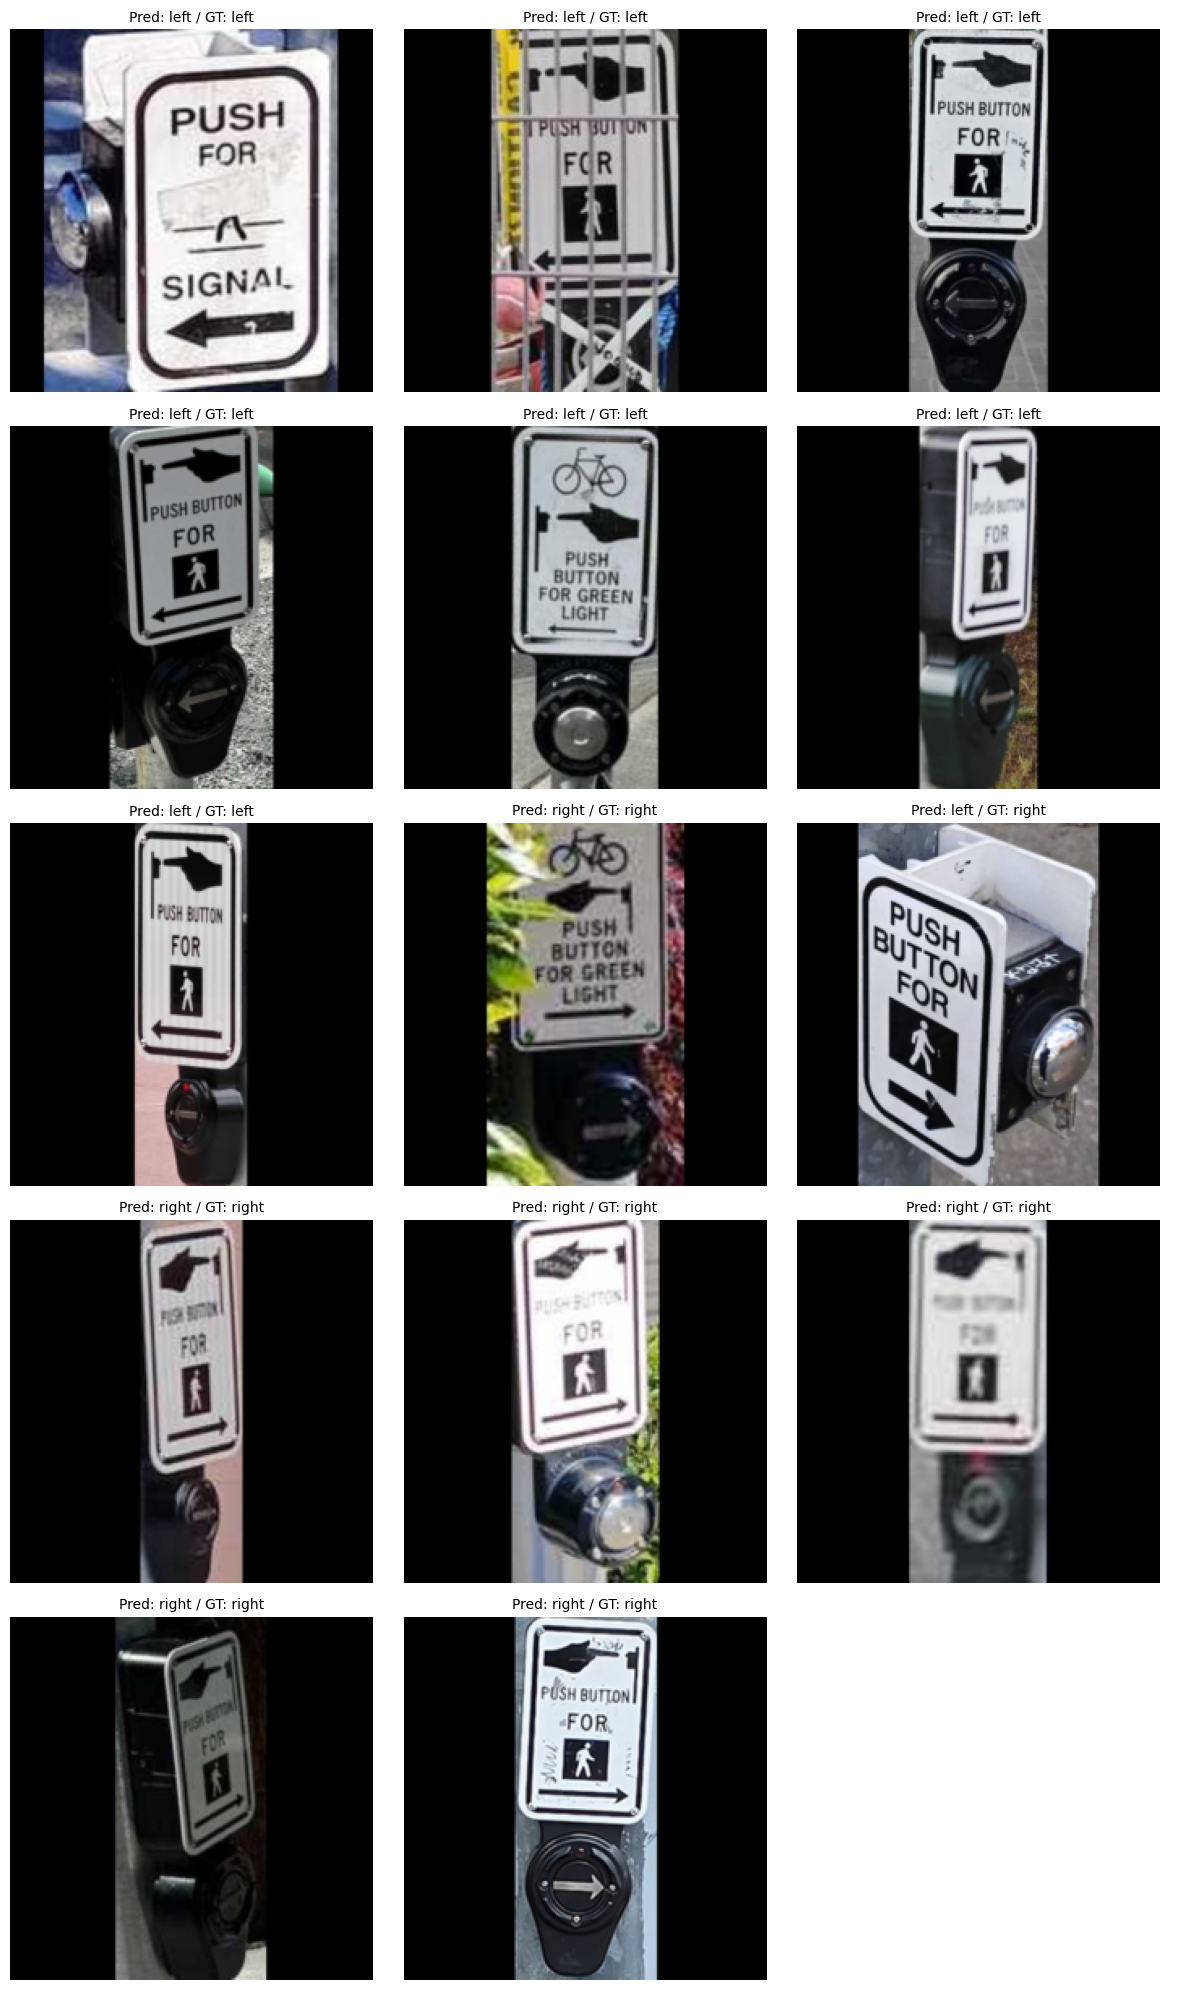

In [24]:
show_predictions_grid(loader_test, final_model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [25]:
torch.save(final_model.state_dict(), "vit-wo.pth")